# Monet Style Transfer with GANs - Kaggle Mini-Project
### Author: Tomek Mierzwa

This project uses the Kaggle *Monet Paintings* dataset and a CycleGAN model to transform photos into Monet-style paintings.

**Dataset overview:**
- `monet_tfrec`: 300 Monet paintings (256x256, TFRecord)
- `photo_tfrec`: 7,028 photos (256x256, TFRecord)

**Evaluation metric:** MiFID (Memorization-informed Fréchet Inception Distance).

**Deliverables:**
1. Jupyter notebook (this file)
2. Public GitHub repo
3. Kaggle submission (`images.zip` with 7k–10k Monet-style images, 256x256)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, random, zipfile

print('TensorFlow:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Section 1: Dataset Loading (TFRecords only)

In [2]:
# Paths for TFRecord files
monet_tfrecords = tf.io.gfile.glob('./data/gan-getting-started/monet_tfrec/*.tfrec')
photo_tfrecords = tf.io.gfile.glob('./data/gan-getting-started/photo_tfrec/*.tfrec')
print('Monet TFRecords:', len(monet_tfrecords))
print('Photo TFRecords:', len(photo_tfrecords))

Monet TFRecords: 5
Photo TFRecords: 20


In [3]:
# TFRecord parsing utilities
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    return decode_image(example['image'])

def load_dataset(filenames, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(2048).batch(batch_size)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

monet_ds = load_dataset(monet_tfrecords)
photo_ds = load_dataset(photo_tfrecords)


2025-09-29 14:12:48.859494: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-29 14:12:48.859713: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-09-29 14:12:48.859728: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2025-09-29 14:12:48.860015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-29 14:12:48.860045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-09-29 14:12:58.292324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-29 14:12:58.609637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


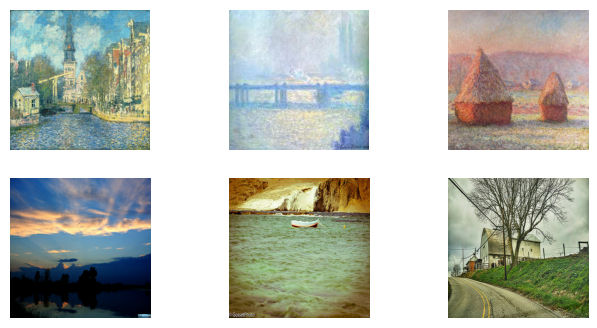

In [4]:
# Visualize few Monet vs Photo samples
plt.figure(figsize=(8,4))
for i, img in enumerate(monet_ds.take(3)):
    plt.subplot(2,3,i+1)
    plt.imshow((img[0].numpy()+1)/2)
    plt.axis('off')
    if i==0: plt.ylabel('Monet')
for i, img in enumerate(photo_ds.take(3)):
    plt.subplot(2,3,i+4)
    plt.imshow((img[0].numpy()+1)/2)
    plt.axis('off')
    if i==0: plt.ylabel('Photo')
plt.show()

## Section 2: CycleGAN Model

In [5]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(0., 0.02),
                             use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down1 = downsample(64,4,apply_batchnorm=False)(inputs)
    down2 = downsample(128,4)(down1)
    up1 = upsample(64,4)(down2)
    last = layers.Conv2DTranspose(3,4,strides=2,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                  activation='tanh')(up1)
    return tf.keras.Model(inputs=inputs, outputs=last)

def Discriminator():
    inp = layers.Input(shape=[256,256,3])
    x = layers.Conv2D(64,4,strides=2,padding='same')(inp)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128,4,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1,4,strides=1,padding='same')(x)
    return tf.keras.Model(inputs=inp, outputs=x)


In [6]:
# Instantiate models
gen_g = Generator()  # Photo->Monet
gen_f = Generator()  # Monet->Photo
disc_x = Discriminator()
disc_y = Discriminator()

print("Generator G (Photo -> Monet):")
gen_g.summary()
print("\nGenerator F (Monet -> Photo):")
gen_f.summary()
print("\nDiscriminator X:")
disc_x.summary()
print("\nDiscriminator Y:")
disc_y.summary()

Generator G (Photo -> Monet):


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 64)   │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,059 (1.03 MB)

 Trainable params: 268,675 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)


Generator F (Monet -> Photo):


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128, 128, 64)   │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,059 (1.03 MB)

 Trainable params: 268,675 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator X:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,897 (534.75 KB)

 Trainable params: 136,641 (533.75 KB)

 Non-trainable params: 256 (1.00 KB)


Discriminator Y:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,897 (534.75 KB)

 Trainable params: 136,641 (533.75 KB)

 Non-trainable params: 256 (1.00 KB)

## Section 3: Training Loop

In [9]:
# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5

def cycle_loss(real_image, cycled_image):
    return LAMBDA_CYCLE * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA_IDENTITY * tf.reduce_mean(tf.abs(real_image - same_image))

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Full training step
@tf.function
def train_step(real_x, real_y):
    # real_x = photos, real_y = monets
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates Photo -> Monet
        # Generator F translates Monet -> Photo
        fake_y = gen_g(real_x, training=True)
        fake_x = gen_f(real_y, training=True)

        cycled_x = gen_f(fake_y, training=True)
        cycled_y = gen_g(fake_x, training=True)

        same_x = gen_f(real_x, training=True)
        same_y = gen_g(real_y, training=True)

        disc_real_x = disc_x(real_x, training=True)
        disc_real_y = disc_y(real_y, training=True)

        disc_fake_x = disc_x(fake_x, training=True)
        disc_fake_y = disc_y(fake_y, training=True)

        # Generator adversarial loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Cycle loss
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Identity loss
        id_loss_g = identity_loss(real_y, same_y)
        id_loss_f = identity_loss(real_x, same_x)

        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_f

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate and apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, disc_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, disc_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, gen_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, gen_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, disc_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, disc_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss
    }

EPOCHS = 25

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, (photo, monet) in enumerate(tf.data.Dataset.zip((photo_ds, monet_ds))):
        losses = train_step(photo, monet)
        if step % 100 == 0:
            print(f"  Step {step}: "
                  f"G_g={losses['gen_g_loss'].numpy():.3f}, "
                  f"G_f={losses['gen_f_loss'].numpy():.3f}, "
                  f"D_x={losses['disc_x_loss'].numpy():.3f}, "
                  f"D_y={losses['disc_y_loss'].numpy():.3f}")

Epoch 1/25
  Step 0: G_g=3.746, G_f=3.562, D_x=0.752, D_y=0.718
  Step 100: G_g=5.232, G_f=3.828, D_x=0.467, D_y=0.607
  Step 200: G_g=4.752, G_f=4.581, D_x=0.636, D_y=0.491


2025-09-29 14:23:24.629693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/25
  Step 0: G_g=5.832, G_f=6.482, D_x=0.445, D_y=0.517
  Step 100: G_g=3.562, G_f=4.092, D_x=0.486, D_y=0.612
  Step 200: G_g=3.835, G_f=4.006, D_x=0.507, D_y=0.560


2025-09-29 14:23:52.552645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/25
  Step 0: G_g=4.168, G_f=3.237, D_x=0.412, D_y=0.541
  Step 100: G_g=3.902, G_f=4.411, D_x=0.388, D_y=0.614
  Step 200: G_g=4.185, G_f=4.697, D_x=0.420, D_y=0.471


2025-09-29 14:24:20.681690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/25
  Step 0: G_g=4.013, G_f=3.665, D_x=0.629, D_y=0.788
  Step 100: G_g=4.025, G_f=4.844, D_x=0.740, D_y=0.713
  Step 200: G_g=3.811, G_f=4.101, D_x=0.408, D_y=0.515


2025-09-29 14:24:48.733147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/25
  Step 0: G_g=4.669, G_f=3.926, D_x=0.408, D_y=0.462
  Step 100: G_g=4.661, G_f=4.793, D_x=0.762, D_y=0.585
  Step 200: G_g=3.286, G_f=3.221, D_x=0.678, D_y=0.675


2025-09-29 14:25:16.869102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/25
  Step 0: G_g=3.272, G_f=3.295, D_x=0.599, D_y=0.682
  Step 100: G_g=4.439, G_f=3.696, D_x=0.749, D_y=0.549
  Step 200: G_g=4.059, G_f=3.680, D_x=0.525, D_y=0.435


2025-09-29 14:25:44.979538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/25
  Step 0: G_g=3.691, G_f=4.186, D_x=0.625, D_y=0.691
  Step 100: G_g=3.796, G_f=3.715, D_x=0.528, D_y=0.447
  Step 200: G_g=3.619, G_f=3.492, D_x=0.326, D_y=0.379


2025-09-29 14:26:13.101712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/25
  Step 0: G_g=3.579, G_f=3.369, D_x=0.668, D_y=0.664
  Step 100: G_g=3.982, G_f=3.051, D_x=0.605, D_y=0.740
  Step 200: G_g=3.662, G_f=3.315, D_x=0.344, D_y=0.496


2025-09-29 14:26:41.261221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/25
  Step 0: G_g=3.659, G_f=4.131, D_x=0.443, D_y=0.404
  Step 100: G_g=4.189, G_f=4.251, D_x=0.690, D_y=0.696
  Step 200: G_g=3.074, G_f=3.749, D_x=0.700, D_y=0.668


2025-09-29 14:27:09.258132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/25
  Step 0: G_g=5.366, G_f=6.548, D_x=0.554, D_y=0.666
  Step 100: G_g=4.095, G_f=4.360, D_x=0.720, D_y=0.701
  Step 200: G_g=3.634, G_f=3.764, D_x=0.523, D_y=0.602


2025-09-29 14:27:37.177383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/25
  Step 0: G_g=3.487, G_f=4.010, D_x=0.745, D_y=0.547
  Step 100: G_g=3.448, G_f=3.494, D_x=0.355, D_y=0.416
  Step 200: G_g=3.481, G_f=3.678, D_x=0.620, D_y=0.623


2025-09-29 14:28:05.155307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/25
  Step 0: G_g=3.684, G_f=4.118, D_x=0.565, D_y=0.566
  Step 100: G_g=4.735, G_f=6.520, D_x=0.745, D_y=0.826
  Step 200: G_g=5.131, G_f=5.114, D_x=0.483, D_y=0.396


2025-09-29 14:28:33.322523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/25
  Step 0: G_g=5.053, G_f=3.994, D_x=0.451, D_y=0.313
  Step 100: G_g=3.517, G_f=3.138, D_x=0.785, D_y=0.611
  Step 200: G_g=4.253, G_f=4.015, D_x=0.436, D_y=0.711


2025-09-29 14:29:01.349764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/25
  Step 0: G_g=4.469, G_f=4.781, D_x=0.596, D_y=0.529
  Step 100: G_g=3.975, G_f=4.401, D_x=0.564, D_y=0.584
  Step 200: G_g=4.042, G_f=4.521, D_x=0.661, D_y=0.685


2025-09-29 14:29:29.347382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/25
  Step 0: G_g=5.092, G_f=4.594, D_x=0.778, D_y=0.552
  Step 100: G_g=3.316, G_f=3.099, D_x=0.734, D_y=0.781
  Step 200: G_g=3.490, G_f=3.346, D_x=0.513, D_y=0.532


2025-09-29 14:29:57.462832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/25
  Step 0: G_g=3.712, G_f=3.954, D_x=0.616, D_y=0.519
  Step 100: G_g=4.065, G_f=4.501, D_x=0.571, D_y=0.637
  Step 200: G_g=3.624, G_f=3.529, D_x=0.356, D_y=0.549


2025-09-29 14:30:25.648453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17/25
  Step 0: G_g=3.550, G_f=4.397, D_x=0.532, D_y=0.549
  Step 100: G_g=5.688, G_f=5.434, D_x=0.447, D_y=0.713
  Step 200: G_g=3.579, G_f=3.833, D_x=0.661, D_y=0.566


2025-09-29 14:30:53.807757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/25
  Step 0: G_g=4.316, G_f=3.924, D_x=0.995, D_y=0.864
  Step 100: G_g=4.025, G_f=3.991, D_x=0.445, D_y=0.455
  Step 200: G_g=3.685, G_f=4.112, D_x=0.627, D_y=0.502


2025-09-29 14:31:21.852700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/25
  Step 0: G_g=5.091, G_f=4.290, D_x=0.497, D_y=0.470
  Step 100: G_g=4.560, G_f=4.435, D_x=0.368, D_y=0.325
  Step 200: G_g=4.613, G_f=4.617, D_x=0.364, D_y=0.470


2025-09-29 14:31:50.047831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/25
  Step 0: G_g=5.233, G_f=5.316, D_x=0.720, D_y=0.510
  Step 100: G_g=3.420, G_f=4.343, D_x=0.554, D_y=0.609
  Step 200: G_g=4.295, G_f=4.090, D_x=0.480, D_y=0.464


2025-09-29 14:32:18.236729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/25
  Step 0: G_g=3.360, G_f=3.193, D_x=0.905, D_y=0.853
  Step 100: G_g=4.283, G_f=4.127, D_x=0.492, D_y=0.396
  Step 200: G_g=4.177, G_f=3.921, D_x=0.282, D_y=0.421


2025-09-29 14:32:46.428695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/25
  Step 0: G_g=5.302, G_f=6.356, D_x=0.500, D_y=0.634
  Step 100: G_g=3.121, G_f=3.222, D_x=0.412, D_y=0.370
  Step 200: G_g=3.436, G_f=3.959, D_x=0.712, D_y=0.594


2025-09-29 14:33:14.683352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23/25
  Step 0: G_g=4.109, G_f=5.234, D_x=0.395, D_y=0.573
  Step 100: G_g=3.432, G_f=4.091, D_x=0.463, D_y=0.698
  Step 200: G_g=4.786, G_f=4.398, D_x=0.343, D_y=0.384


2025-09-29 14:33:43.017788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24/25
  Step 0: G_g=3.461, G_f=3.047, D_x=0.372, D_y=0.499
  Step 100: G_g=4.029, G_f=3.538, D_x=0.570, D_y=0.475
  Step 200: G_g=4.556, G_f=4.195, D_x=0.285, D_y=0.429


2025-09-29 14:34:11.838029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/25
  Step 0: G_g=3.135, G_f=3.132, D_x=0.540, D_y=0.452
  Step 100: G_g=3.451, G_f=3.212, D_x=0.500, D_y=0.635
  Step 200: G_g=4.130, G_f=4.595, D_x=0.513, D_y=0.524


2025-09-29 14:34:41.312057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Section 4: Results & Visualization

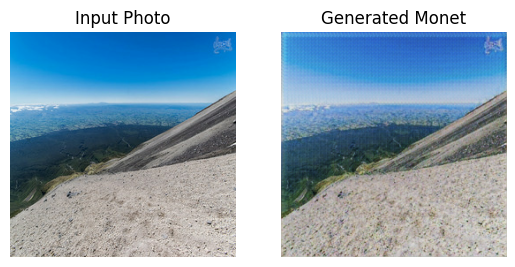

In [18]:
sample_photo = next(iter(photo_ds))[0]
generated_monet = gen_g(tf.expand_dims(sample_photo,0), training=False)[0]
plt.subplot(1,2,1); plt.imshow((sample_photo.numpy()+1)/2); plt.title('Input Photo'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow((generated_monet.numpy()+1)/2); plt.title('Generated Monet'); plt.axis('off')
plt.show()

## Section 5: Kaggle Submission

In [14]:
# Generate Monet-style images for all photos and save as JPEGs in ./images/
import PIL.Image
os.makedirs('images', exist_ok=True)
count = 0
for batch in photo_ds.take(-1):
    for img in batch:
        gen_img = gen_g(tf.expand_dims(img,0), training=False)[0].numpy()
        gen_img = ((gen_img+1)*127.5).astype(np.uint8)
        PIL.Image.fromarray(gen_img).save(f'images/{count}.jpg')
        count += 1

# Zip for Kaggle
with zipfile.ZipFile('images.zip', 'w') as z:
    for fname in os.listdir('images'):
        z.write(os.path.join('images', fname), fname)
print('Created images.zip with', count, 'files')

2025-09-29 14:38:23.273801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Created images.zip with 7038 files


## Section 6: Conclusion

- CycleGAN with TFRecord input successfully generates Monet-style outputs.
- This demo trained for only a few steps, so results are coarse.
- For leaderboard submission, train longer (50+ epochs).
- Future improvements: more epochs, regularization, pretrained discriminators.
